In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import pydeseq2
import matplotlib.pyplot as plt
import scipy.spatial.distance
import decoupler as dc
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import matplotlib

In [4]:
DIR_WORKSPACE = '/node200data/18parkky/datasets'

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

## Load data

In [3]:
adata_chen      = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')
adata_joanito   = sc.read_h5ad(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.h5ad')

adata_epi_chen      = adata_chen[adata_chen.obs['Manual_CellType_lvl_1']!='N/A'].copy()
adata_epi_joanito   = adata_joanito[adata_joanito.obs['Manual_CellType_lvl_1']!='N/A'].copy()

adata_epi_joanito   = adata_epi_joanito.raw.to_adata()
adata_epi_chen      = adata_epi_chen.raw.to_adata()

In [5]:
chen_patient_metadata = pd.read_csv(f'{DIR_WORKSPACE}/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorStage = { list(tup)[1] : list(tup)[7] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in chen_patient_metadata.itertuples() }
dict_PatientID_to_Age = { list(tup)[1] : list(tup)[2] for tup in chen_patient_metadata.itertuples() }

adata_epi_chen.obs['TumorStage'] = [ dict_PatientID_to_TumorStage[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_epi_chen.obs['PatientID'] ]
adata_epi_chen.obs['Age'] = [ dict_PatientID_to_Age[PID] for PID in adata_epi_chen.obs['PatientID'] ]

chen_patient_order_by_MSI_intensity     = ['P18', 'P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_P18 = ['P17', 'P15', 'P26', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

chen_patient_order_by_MSI_intensity_AC  = ['P26', 'P20', 'P21', 'P04']
chen_patient_order_by_MSI_intensity_TC  = ['P19', 'P22', 'P23',]
chen_patient_order_by_MSI_intensity_SC  = ['P18', 'P17', 'P15']

joanito_patient_order_by_MSI_intensity  = ['CRC2817', 'CRC2783', 'SC035', 'SC044']

### Subset tumor cells

In [10]:
adata_epi_chen_tumor = adata_epi_chen[(adata_epi_chen.obs['PatientID'].isin(chen_patient_order_by_MSI_intensity)) & 
                                      (adata_epi_chen.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()
adata_epi_joanito_tumor = adata_epi_joanito[(adata_epi_joanito.obs['PatientID'].isin(joanito_patient_order_by_MSI_intensity)) & 
                                            (adata_epi_joanito.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].copy()

In [14]:
adata_epi_joanito_tumor.raw = adata_epi_joanito_tumor
adata_epi_joanito_tumor.var["mt"] = adata_epi_joanito_tumor.var_names.str.startswith("MT-")
adata_epi_joanito_tumor.var["ribo"] = adata_epi_joanito_tumor.var_names.str.startswith(("RPS", "RPL"))
adata_epi_joanito_tumor.var["hb"] = adata_epi_joanito_tumor.var_names.str.contains("^HB[^(P)]")
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.mt==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.ribo==False].copy()
adata_epi_joanito_tumor = adata_epi_joanito_tumor[:, adata_epi_joanito_tumor.var.hb==False].copy()

adata_epi_chen_tumor.raw = adata_epi_chen_tumor
adata_epi_chen_tumor.var["mt"] = adata_epi_chen_tumor.var_names.str.startswith("MT-")
adata_epi_chen_tumor.var["ribo"] = adata_epi_chen_tumor.var_names.str.startswith(("RPS", "RPL"))
adata_epi_chen_tumor.var["hb"] = adata_epi_chen_tumor.var_names.str.contains("^HB[^(P)]")
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.mt==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.ribo==False].copy()
adata_epi_chen_tumor = adata_epi_chen_tumor[:, adata_epi_chen_tumor.var.hb==False].copy()

### Sort patients by MSI intensity

In [7]:
dict_PatientID_to_MSI_score = dict()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID', observed=True,):
    dict_PatientID_to_MSI_score[PatientID] = np.mean(edf['MSI_score'])
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
# dict_PatientID_to_MSI_score

joanito_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
joanito_patient_order_by_MSI_intensity

['CRC2817', 'CRC2783', 'SC035', 'SC044']

In [8]:
dict_PatientID_to_MSI_score = dict()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID', observed=True,):
    dict_PatientID_to_MSI_score[PatientID] = np.mean(edf['MSI_score'])
dict_PatientID_to_MSI_score = dict(sorted(dict_PatientID_to_MSI_score.items(), key=lambda x:x[1]))
# dict_PatientID_to_MSI_score

chen_patient_order_by_MSI_intensity = list(dict_PatientID_to_MSI_score.keys())
chen_patient_order_by_MSI_intensity

['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04']

## Assign MSI class

In [15]:
dict_PatientID_to_MSI_class = dict()

### Joanito et al

/tmp/ipykernel_18818/3902217933.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID'):


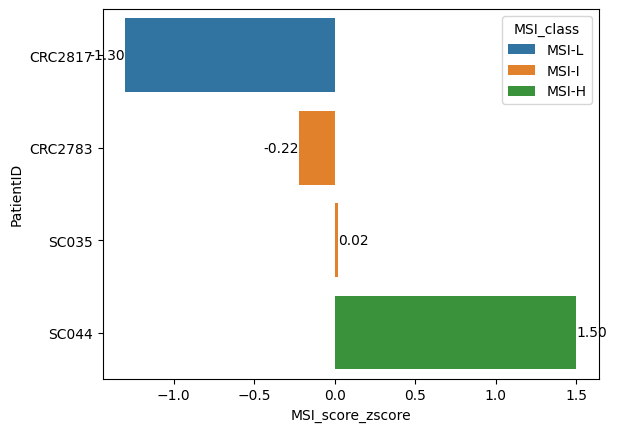

In [17]:
MSIintensityByPatient_Joanito = list()
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_Joanito.append( [PatientID, np.mean(edf['MSI_score'])] )
MSIintensityByPatient_Joanito = pd.DataFrame(MSIintensityByPatient_Joanito, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_Joanito['MSI_score']), np.std(MSIintensityByPatient_Joanito['MSI_score'])
MSIintensityByPatient_Joanito['MSI_score_zscore'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_Joanito['MSI_score'] ]

for tup in MSIintensityByPatient_Joanito.itertuples():
    if tup.MSI_score_zscore < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-L'
    elif tup.MSI_score_zscore > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-H'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-I'

MSIintensityByPatient_Joanito['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_Joanito['PatientID'] ]
ax = sns.barplot(data=MSIintensityByPatient_Joanito.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore', hue='MSI_class')
ax.bar_label(fmt='%.2f', container=ax.containers[0]);
ax.bar_label(fmt='%.2f', container=ax.containers[1]);
ax.bar_label(fmt='%.2f', container=ax.containers[2]);

### Chen et al

/tmp/ipykernel_18818/963375767.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID'):


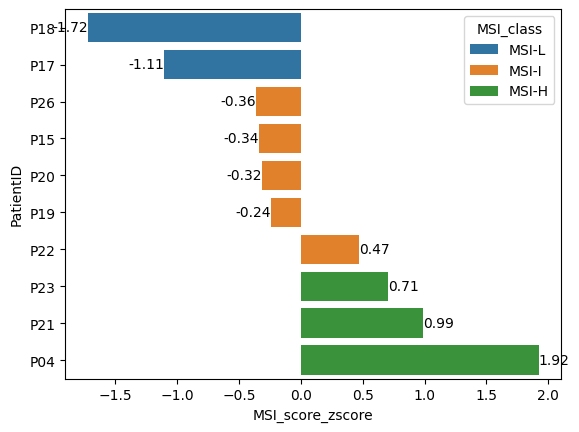

In [18]:
MSIintensityByPatient_Chen = list()
for PatientID, edf in adata_epi_chen_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_Chen.append( [PatientID, np.mean(edf['MSI_score'])] )
MSIintensityByPatient_Chen = pd.DataFrame(MSIintensityByPatient_Chen, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_Chen['MSI_score']), np.std(MSIintensityByPatient_Chen['MSI_score'])
MSIintensityByPatient_Chen['MSI_score_zscore'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_Chen['MSI_score'] ]

for tup in MSIintensityByPatient_Chen.itertuples():
    if tup.MSI_score_zscore < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-L'
    elif tup.MSI_score_zscore > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-H'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-I'
        
MSIintensityByPatient_Chen['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_Chen['PatientID'] ]
ax = sns.barplot(data=MSIintensityByPatient_Chen.sort_values('MSI_score_zscore'), y='PatientID', x='MSI_score_zscore', hue='MSI_class')
ax.bar_label(fmt='%.2f', container=ax.containers[0]);
ax.bar_label(fmt='%.2f', container=ax.containers[1]);
ax.bar_label(fmt='%.2f', container=ax.containers[2]);

In [19]:
dict_PatientID_to_MSI_class = dict(sorted(dict_PatientID_to_MSI_class.items(), key=lambda x:x[1]))
dict_PatientID_to_MSI_class

{'SC044': 'MSI-H',
 'P04': 'MSI-H',
 'P21': 'MSI-H',
 'P23': 'MSI-H',
 'CRC2783': 'MSI-I',
 'SC035': 'MSI-I',
 'P15': 'MSI-I',
 'P19': 'MSI-I',
 'P20': 'MSI-I',
 'P22': 'MSI-I',
 'P26': 'MSI-I',
 'CRC2817': 'MSI-L',
 'P17': 'MSI-L',
 'P18': 'MSI-L'}

In [20]:
adata_epi_joanito_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_joanito_tumor.obs['PatientID'] ]
adata_epi_chen_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_epi_chen_tumor.obs['PatientID'] ]

## Identifying DEGs using Scanpy

### Joanito et al

In [196]:
# adata_epi_joanito_tumor_MSI_H = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-H'].copy()
# adata_epi_joanito_tumor_MSI_L = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-L'].copy()

# intersecting_genes = set(adata_epi_joanito_tumor_MSI_H.var.index).intersection(set(adata_epi_joanito_tumor_MSI_L.var.index))
# print(f'MSI-H\tMSI-L\tI') # MSI-H, MSI-L, Intersections
# print(adata_epi_joanito_tumor_MSI_H.var.shape[0], adata_epi_joanito_tumor_MSI_L.var.shape[0], len(intersecting_genes))
# minimum_cell_percentage = 0.03
# sc.pp.filter_genes(adata_epi_joanito_tumor_MSI_H, min_cells=int(adata_epi_joanito_tumor_MSI_H.obs.shape[0]*minimum_cell_percentage))
# sc.pp.filter_genes(adata_epi_joanito_tumor_MSI_L, min_cells=int(adata_epi_joanito_tumor_MSI_L.obs.shape[0]*minimum_cell_percentage))
# intersecting_genes = set(adata_epi_joanito_tumor_MSI_H.var.index).union(set(adata_epi_joanito_tumor_MSI_L.var.index))
# print(adata_epi_joanito_tumor_MSI_H.var.shape[0], adata_epi_joanito_tumor_MSI_L.var.shape[0], len(intersecting_genes))

# adata_epi_joanito_tumor_MSI_H = adata_epi_joanito_tumor_MSI_H[:, adata_epi_joanito_tumor_MSI_H.var.index.isin( intersecting_genes )].copy()
# adata_epi_joanito_tumor_MSI_L = adata_epi_joanito_tumor_MSI_L[:, adata_epi_joanito_tumor_MSI_L.var.index.isin( intersecting_genes )].copy()

#!
adata_epi_joanito_tumor_MSI_H = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-H'].copy()
adata_epi_joanito_tumor_MSI_L = adata_epi_joanito_tumor[adata_epi_joanito_tumor.obs['MSI_class']=='MSI-L'].copy()

adata_epi_joanito_tumor_DEG_ident = sc.concat([adata_epi_joanito_tumor_MSI_H, adata_epi_joanito_tumor_MSI_L])

minimum_cell_percentage = 0.03
sc.pp.filter_genes(adata_epi_joanito_tumor_DEG_ident, min_cells=int(adata_epi_joanito_tumor_DEG_ident.obs.shape[0]*minimum_cell_percentage))
adata_epi_joanito_tumor_DEG_ident.shape

(1700, 13112)

In [197]:
# adata_epi_joanito_tumor_DEG_ident = sc.concat([adata_epi_joanito_tumor_MSI_H, adata_epi_joanito_tumor_MSI_L])

sc.pp.normalize_total(adata_epi_joanito_tumor_DEG_ident)
sc.pp.log1p(adata_epi_joanito_tumor_DEG_ident)
adata_epi_joanito_tumor_DEG_ident.raw = adata_epi_joanito_tumor_DEG_ident

In [198]:
sc.tl.rank_genes_groups(adata_epi_joanito_tumor_DEG_ident, groupby='MSI_class', method='wilcoxon', )

In [199]:
joanito_tumor_DEG_names = pd.DataFrame(adata_epi_joanito_tumor_DEG_ident.uns['rank_genes_groups']['names'])
joanito_tumor_DEG_score = pd.DataFrame(adata_epi_joanito_tumor_DEG_ident.uns['rank_genes_groups']['scores'])
joanito_tumor_DEG_lfc   = pd.DataFrame(adata_epi_joanito_tumor_DEG_ident.uns['rank_genes_groups']['logfoldchanges'])
joanito_tumor_DEG_p  = pd.DataFrame(adata_epi_joanito_tumor_DEG_ident.uns['rank_genes_groups']['pvals'])
joanito_tumor_DEG_adjp  = pd.DataFrame(adata_epi_joanito_tumor_DEG_ident.uns['rank_genes_groups']['pvals_adj'])

joanito_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI-H', 1 : 'MSI-L' }

for tup in joanito_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        joanito_tumor_DEG_summary.append( [elem, 
                                           list(joanito_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

joanito_tumor_DEG_summary = pd.DataFrame(joanito_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])

In [430]:
adata_epi_joanito_tumor_DEG_ident.write(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/3_DEG_identification/Joanito.preprocessed.NanoMnT.ManualAnnot.Epi.DEGs.h5ad')

In [200]:
joanito_tumor_DEG_summary.to_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t', index=False)

### Chen et al

In [201]:
adata_epi_chen_tumor_MSI_H = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']=='MSI-H'].copy()
adata_epi_chen_tumor_MSI_L = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']=='MSI-L'].copy()

intersecting_genes = set(adata_epi_chen_tumor_MSI_H.var.index).intersection(set(adata_epi_chen_tumor_MSI_L.var.index))
print(f'MSI-H\tMSI-L\tI') # MSI-H, MSI-L, Intersections
print(adata_epi_chen_tumor_MSI_H.var.shape[0], adata_epi_chen_tumor_MSI_L.var.shape[0], len(intersecting_genes))
minimum_cell_percentage = 0.01
sc.pp.filter_genes(adata_epi_chen_tumor_MSI_H, min_cells=int(adata_epi_chen_tumor_MSI_H.obs.shape[0]*minimum_cell_percentage))
sc.pp.filter_genes(adata_epi_chen_tumor_MSI_L, min_cells=int(adata_epi_chen_tumor_MSI_L.obs.shape[0]*minimum_cell_percentage))
intersecting_genes = set(adata_epi_chen_tumor_MSI_H.var.index).union(set(adata_epi_chen_tumor_MSI_L.var.index))
print(adata_epi_chen_tumor_MSI_H.var.shape[0], adata_epi_chen_tumor_MSI_L.var.shape[0], len(intersecting_genes))

adata_epi_chen_tumor_MSI_H = adata_epi_chen_tumor_MSI_H[:, adata_epi_chen_tumor_MSI_H.var.index.isin( intersecting_genes )].copy()
adata_epi_chen_tumor_MSI_L = adata_epi_chen_tumor_MSI_L[:, adata_epi_chen_tumor_MSI_L.var.index.isin( intersecting_genes )].copy()

MSI-H	MSI-L	I
28851 28851 28851
15090 15036 16164


In [202]:
adata_epi_chen_tumor_MSI_H = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']=='MSI-H'].copy()
adata_epi_chen_tumor_MSI_L = adata_epi_chen_tumor[adata_epi_chen_tumor.obs['MSI_class']=='MSI-L'].copy()

adata_epi_chen_tumor_DEG_ident = sc.concat([adata_epi_chen_tumor_MSI_H, adata_epi_chen_tumor_MSI_L])

minimum_cell_percentage = 0.03
sc.pp.filter_genes(adata_epi_chen_tumor_DEG_ident, min_cells=int(adata_epi_chen_tumor_DEG_ident.obs.shape[0]*minimum_cell_percentage))
adata_epi_chen_tumor_DEG_ident.shape,

((8723, 12139),)

In [203]:
# adata_epi_chen_tumor_DEG_ident = sc.concat([adata_epi_chen_tumor_MSI_H, adata_epi_chen_tumor_MSI_L])

sc.pp.normalize_total(adata_epi_chen_tumor_DEG_ident)
sc.pp.log1p(adata_epi_chen_tumor_DEG_ident)
adata_epi_chen_tumor_DEG_ident.raw = adata_epi_chen_tumor_DEG_ident

In [204]:
sc.tl.rank_genes_groups(adata_epi_chen_tumor_DEG_ident, groupby='MSI_class', method='wilcoxon', )

In [205]:
chen_tumor_DEG_names = pd.DataFrame(adata_epi_chen_tumor_DEG_ident.uns['rank_genes_groups']['names'])
chen_tumor_DEG_score = pd.DataFrame(adata_epi_chen_tumor_DEG_ident.uns['rank_genes_groups']['scores'])
chen_tumor_DEG_lfc   = pd.DataFrame(adata_epi_chen_tumor_DEG_ident.uns['rank_genes_groups']['logfoldchanges'])
chen_tumor_DEG_p  = pd.DataFrame(adata_epi_chen_tumor_DEG_ident.uns['rank_genes_groups']['pvals'])
chen_tumor_DEG_adjp  = pd.DataFrame(adata_epi_chen_tumor_DEG_ident.uns['rank_genes_groups']['pvals_adj'])

chen_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI-H', 1 : 'MSI-L' }

for tup in chen_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        chen_tumor_DEG_summary.append( [elem, 
                                           list(chen_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

chen_tumor_DEG_summary = pd.DataFrame(chen_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])

In [431]:
adata_epi_chen_tumor_DEG_ident.write(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/Chen.preprocessed.NanoMnT.ManualAnnot.Epi.DEGs.h5ad')

In [206]:
chen_tumor_DEG_summary.to_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t', index=False)

## Visualize DEGs through volcano plot

In [439]:
joanito_tumor_DEG_summary   = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Joanito_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/3_DEG_identification/ScanpyRankGenesGroups.summary.tsv', sep='\t')

joanito_tumor_DEG_summary   = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['MSI_class']=='MSI-H'].copy()
chen_tumor_DEG_summary      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['MSI_class']=='MSI-H'].copy()

In [449]:
joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)].copy()
chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)].copy()

In [450]:
joanito_down = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']<=-1) ]
joanito_up = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']>=1) ]

chen_down = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']<=-1) ]
chen_up = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']>=1) ]

print(f'Joanito up: {len(joanito_up)}\tJoanito down: {len(joanito_down)}')
print(f'Chen up: {len(chen_up)}\tChen down: {len(chen_down)}')

Joanito up: 3754	Joanito down: 1225
Chen up: 710	Chen down: 952


In [451]:
intersecting_up     = set(joanito_up['gene']).intersection(set(chen_up['gene']))
intersecting_down   = set(joanito_down['gene']).intersection(set(chen_down['gene']))

print(len(intersecting_up), len(intersecting_down))

239 177


In [293]:
1225-177

1048

### Joanito et al

In [764]:
down.sort_values(['adjusted_pvalue', 'logfoldchanges']).head(20)

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
26222,S100A6,-29.410475,-4.846515,4.034395e-190,5.289899e-186,MSI-H
26218,TFF1,-29.180420,-7.312451,3.436587e-187,1.408205e-183,MSI-H
26212,TFF3,-28.914431,-6.102346,7.862908e-184,1.472835e-180,MSI-H
26210,CD55,-28.832891,-7.557995,8.304018e-183,1.361028e-179,MSI-H
26208,CRIP1,-28.807762,-8.652453,1.714794e-182,2.498264e-179,MSI-H
26206,LYZ,-28.607315,-6.920486,5.448957e-180,5.953894e-177,MSI-H
26204,CEACAM5,-28.597883,-5.116502,7.138591e-180,7.200093e-177,MSI-H
26200,MUC2,-28.488707,-8.693025,1.616786e-178,1.413287e-175,MSI-H
26192,F3,-26.993652,-4.790271,1.754606e-160,6.766585e-158,MSI-H
26186,S100P,-26.611561,-2.800448,4.988552e-156,1.595363e-153,MSI-H


In [606]:
down[down['gene'].isin(['TFF1', 'TFF2', 'TFF3'])]

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
26218,TFF1,-29.18042,-7.312451,3.436587e-187,1.408205e-183,MSI-H


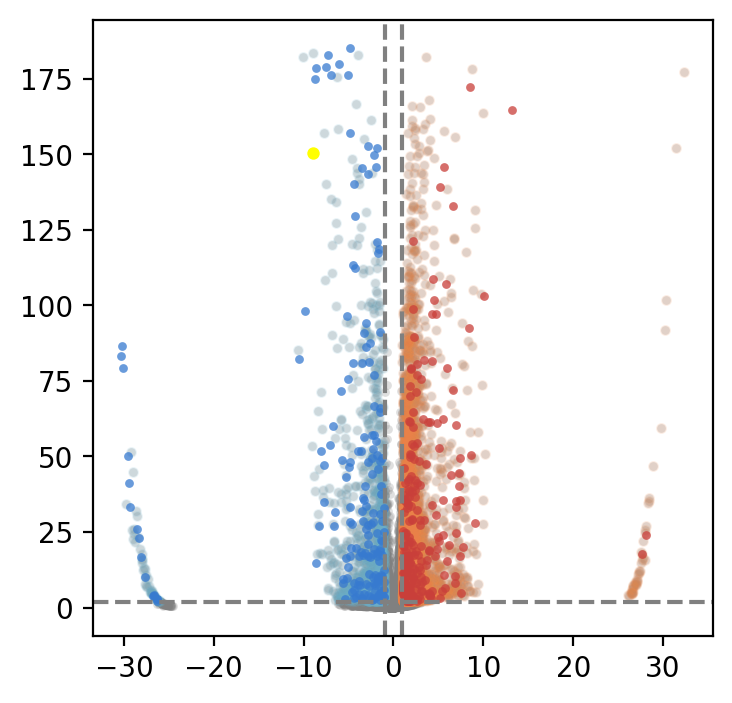

In [766]:
plt.figure(figsize=(4, 4), dpi=200)

geneoi = 'SPINK4'
up      = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up) & (joanito_tumor_DEG_summary['gene']!=geneoi)]
down    = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['gene'].isin(intersecting_down))].copy()
geneoi = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene']==geneoi]

up2     = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']>=1) & (joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']<=-1)&(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
down2   = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})



ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

ax = sns.scatterplot(x=geneoi['logfoldchanges'],y=geneoi['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=20, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('icefire_r', 8)[-1], 
            color='yellow',
            alpha=1, **{'linewidths':0})

# ax.set_xticklabels([]);
# ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-10, 10]);

In [563]:
up['log_adjusted_pvalue'] = [ -np.log10(x) for x in up['adjusted_pvalue'] ]
up[['gene', 'logfoldchanges', 'log_adjusted_pvalue']].head(10)

down['log_adjusted_pvalue'] = [ -np.log10(x) for x in down['adjusted_pvalue'] ]
down[['gene', 'logfoldchanges', 'log_adjusted_pvalue']].head(10)

down.sort_values('log_adjusted_pvalue', ascending=False,).head(10)

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class,log_adjusted_pvalue
24274,REG4,-45.393311,-3.282719,0.000000e+00,1.396189e-306,MSI-H,305.855056
24272,S100A10,-44.566704,-2.097202,0.000000e+00,1.396189e-306,MSI-H,305.855056
24270,CRIP1,-41.980022,-1.999190,0.000000e+00,1.396189e-306,MSI-H,305.855056
24262,S100A11,-37.619415,-1.779126,1.035151e-309,1.396189e-306,MSI-H,305.855056
24276,S100A6,-50.423023,-2.200913,0.000000e+00,1.396189e-306,MSI-H,305.855056
24268,S100P,-41.885979,-2.043056,0.000000e+00,1.396189e-306,MSI-H,305.855056
24260,DST,-37.594528,-2.065336,2.640939e-309,3.205836e-306,MSI-H,305.494059
24246,SH3BGRL3,-34.942291,-1.618135,1.695670e-267,1.210808e-264,MSI-H,263.916925
24244,LGALS3,-34.786072,-1.429296,3.950252e-265,2.523795e-262,MSI-H,261.597946
24236,TMSB4X,-32.529381,-1.396974,4.098365e-232,2.163046e-229,MSI-H,228.664934


In [547]:
down[down['gene']=='S100A6']

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class,log_adjusted_pvalue
24276,S100A6,-50.423023,-2.200913,0.0,0.008464,MSI-H,2.072409


/tmp/ipykernel_18818/3224090602.py:1: UserWarning: The palette list has more values (18) than needed (15), which may not be intended.
  ax = sns.scatterplot(data=down.sort_values('log_adjusted_pvalue', ascending=False,).head(15), x='logfoldchanges',y='log_adjusted_pvalue', s=50,


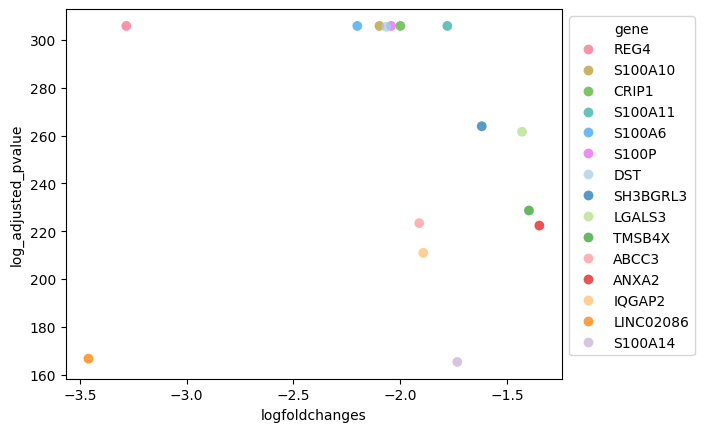

In [569]:

ax = sns.scatterplot(data=down.sort_values('log_adjusted_pvalue', ascending=False,).head(15), x='logfoldchanges',y='log_adjusted_pvalue', s=50,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],    
            hue='gene',
            palette=sns.color_palette('husl')+sns.color_palette('Paired'),
            alpha=.75, **{'linewidths':0})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


### Chen et al

In [597]:
down.sort_values(['adjusted_pvalue', 'logfoldchanges']).iloc[20:30]
down[down['gene'].isin(['TFF1', 'TFF2', 'TFF3'])]

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
22566,TFF1,-11.462366,-2.272822,2.038689e-30,2.361416e-29,MSI-H
23692,TFF3,-17.492407,-1.841420,1.636982e-68,5.535188e-67,MSI-H


In [641]:
chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene']=='ATOH1']

,gene,score,logfoldchanges,pvalue,adjusted_pvalue,MSI_class
18376,ATOH1,-5.610225,-3.270801,2.020636e-08,6.864959e-08,MSI-H


/tmp/ipykernel_18818/1157199941.py:19: RuntimeWarning: divide by zero encountered in log10
  y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
/tmp/ipykernel_18818/1157199941.py:26: RuntimeWarning: divide by zero encountered in log10
  ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
/tmp/ipykernel_18818/1157199941.py:33: RuntimeWarning: divide by zero encountered in log10
  ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,


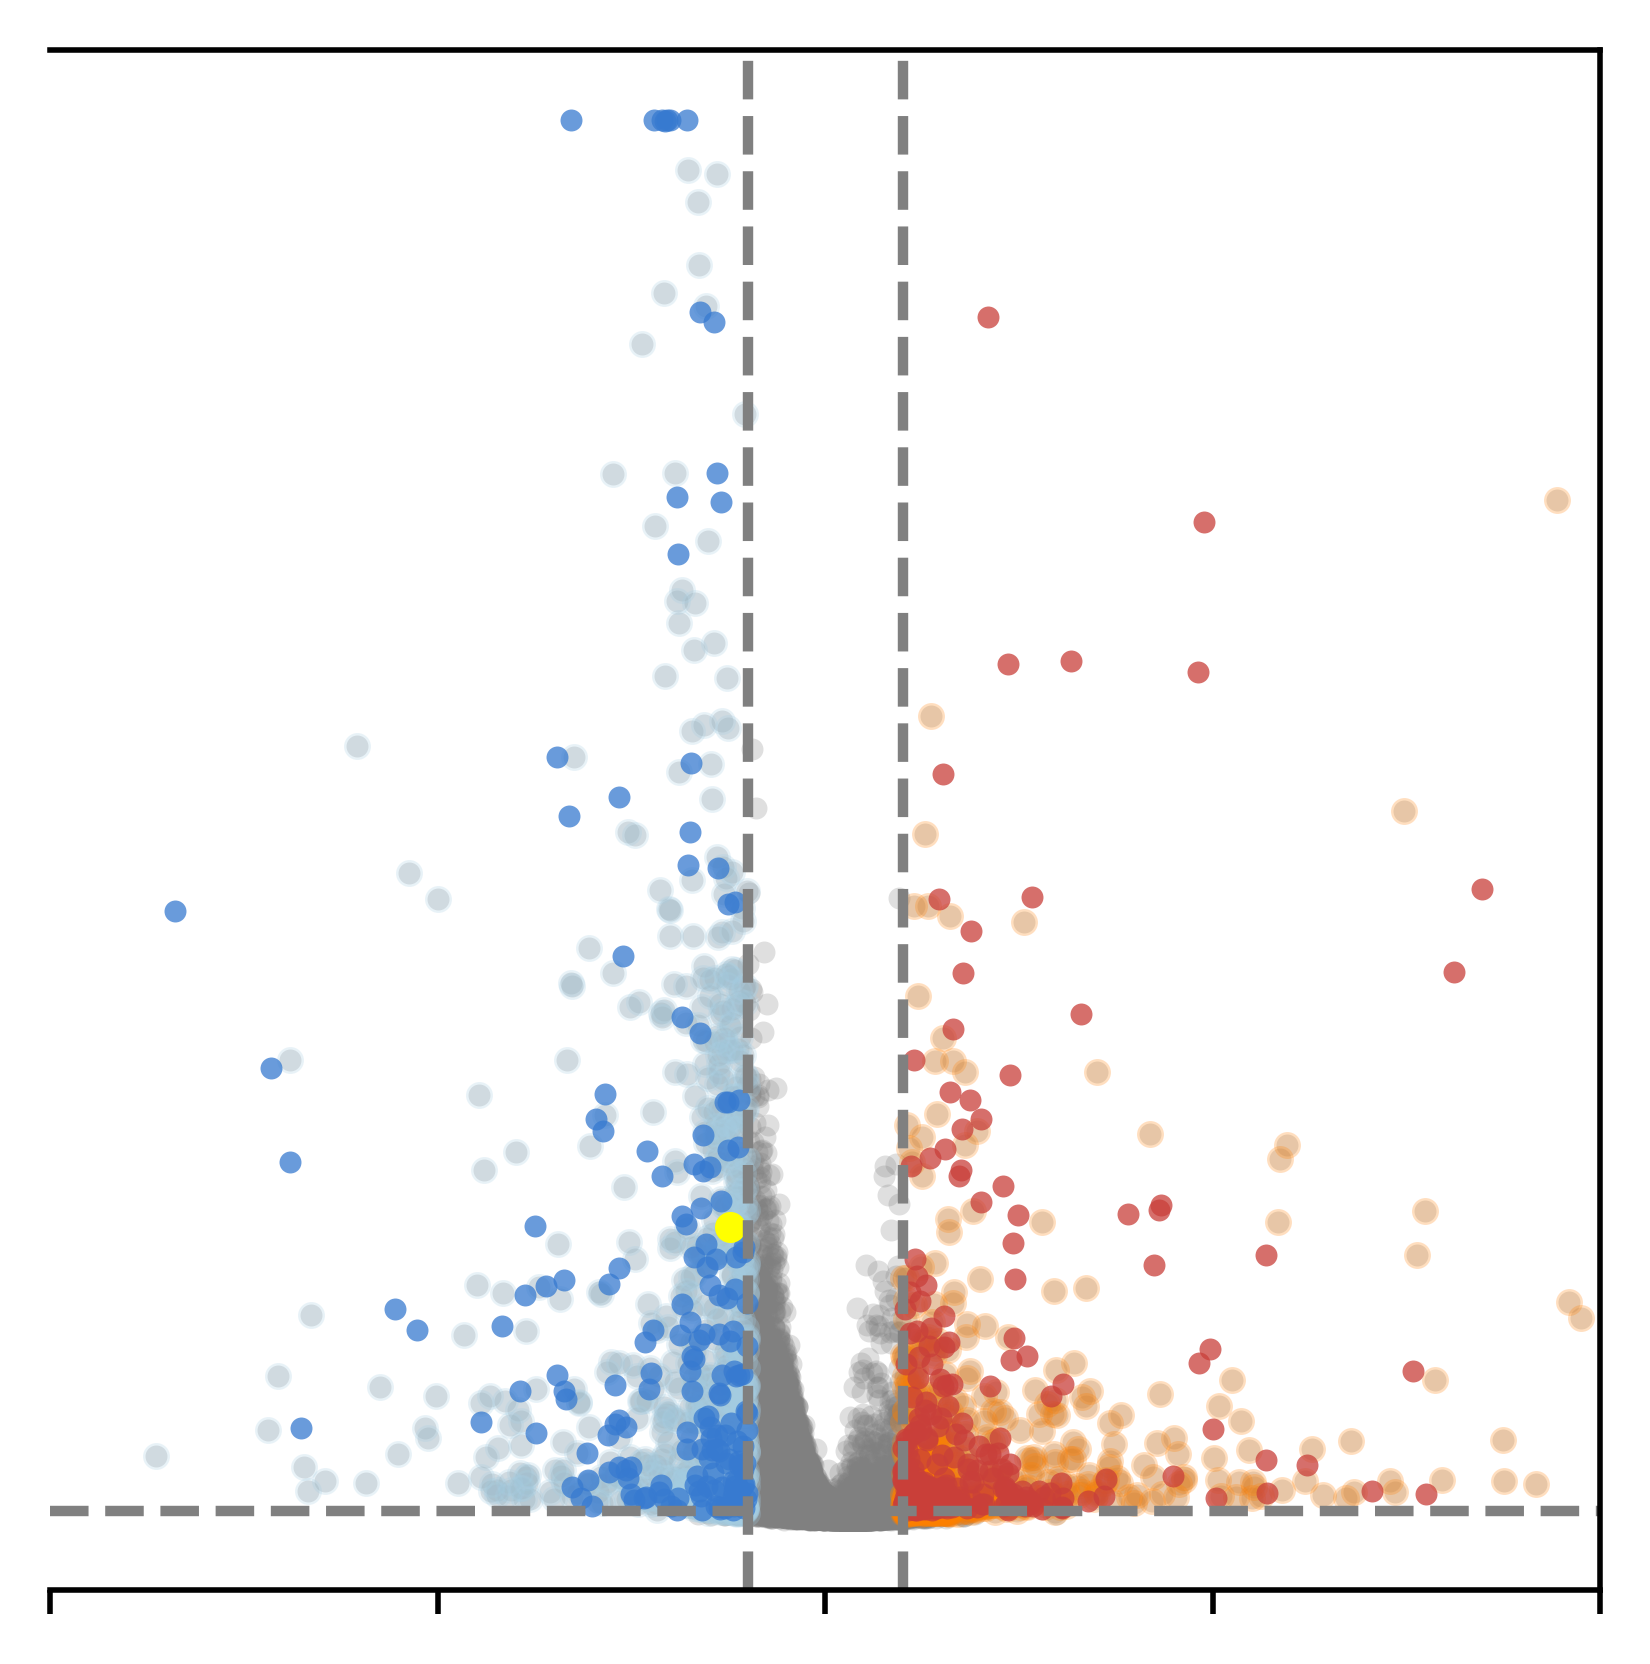

In [770]:
plt.figure(figsize=(4, 4), dpi=500)

geneoi = 'MUC2'

up      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_up)].copy()
down    = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['gene'].isin(intersecting_down) )& (chen_tumor_DEG_summary['gene']!=geneoi)].copy()
down['adjusted_pvalue'] = down['adjusted_pvalue'].replace(0, min(down[(down['adjusted_pvalue']!=0)]['adjusted_pvalue']))
geneoi = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene']==geneoi]

up2     = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']>=1) & (chen_tumor_DEG_summary['adjusted_pvalue']<=0.05)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']<=-1)&(chen_tumor_DEG_summary['adjusted_pvalue']<=0.05)]
down2   = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('icefire_r', 8)[-1], 
            color=sns.color_palette('Paired',8)[0],
            alpha=.25, **{'linewidths':0})


ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('icefire_r', 8)[0], 
            color=sns.color_palette('Paired',8)[-1],
            alpha=.25,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],    
        
            alpha=.75, **{'linewidths':0})

ax = sns.scatterplot(x=geneoi['logfoldchanges'],y=geneoi['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=20, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('icefire_r', 8)[-1], 
            color='yellow',
            alpha=1, **{'linewidths':0})


ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-25, -23]);
plt.xlim([-10, 10]);

# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax.set_yticks([]);
sns.despine(left=True, top=False, right=False,)
# sns.despine(left=False, top=False, right=True,)

/tmp/ipykernel_18818/236874389.py:15: RuntimeWarning: divide by zero encountered in log10
  y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
/tmp/ipykernel_18818/236874389.py:22: RuntimeWarning: divide by zero encountered in log10
  ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
/tmp/ipykernel_18818/236874389.py:27: RuntimeWarning: divide by zero encountered in log10
  ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
/tmp/ipykernel_18818/236874389.py:33: RuntimeWarning: divide by zero encountered in log10
  ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,


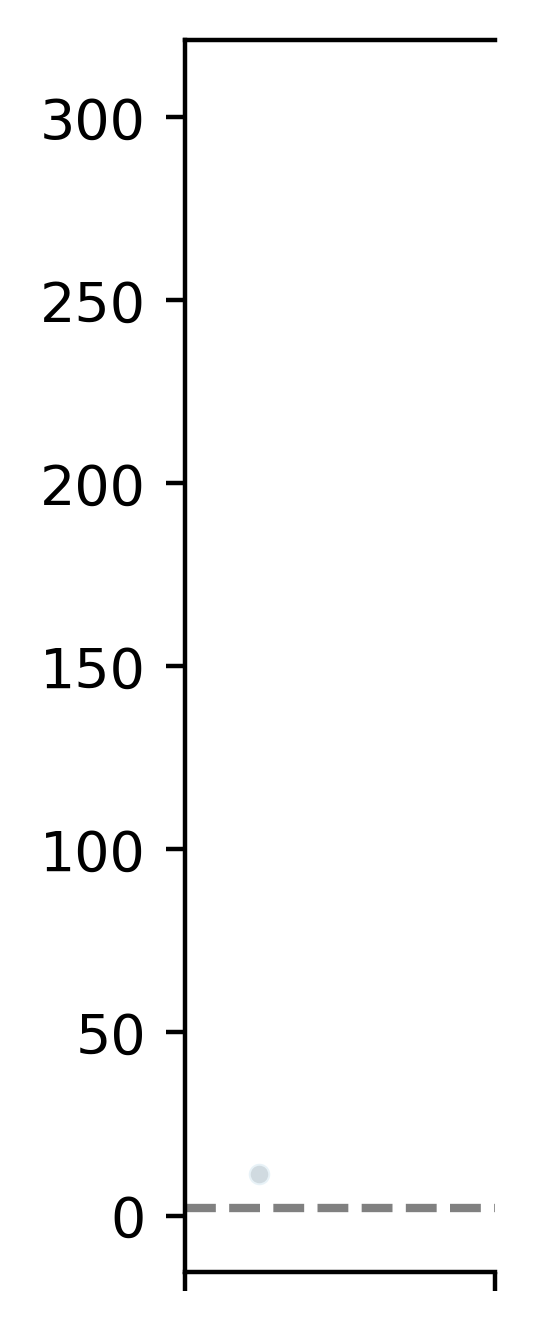

In [283]:
plt.figure(figsize=(1, 4), dpi=400)

up      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_up)]
down    = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_down)]

up2     = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']>=1) & (chen_tumor_DEG_summary['adjusted_pvalue']<=0.05)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']<=-1)&(chen_tumor_DEG_summary['adjusted_pvalue']<=0.05)]
down2   = down2[~down2['gene'].isin(down['gene'])]

# up = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up)]
# down = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_down)]
    
ax = sns.scatterplot(x=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('icefire_r', 8)[-1], 
            color=sns.color_palette('Paired',8)[0],
            alpha=.25, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('icefire_r', 8)[0], 
            color=sns.color_palette('Paired',8)[-1],
            alpha=.25,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})
ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

ax.set_xticklabels([]);
# ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim([-25, -24.5]);

# ax.set_yticks([]);
sns.despine(top=False, right=True)
# ax.xaxis.set_major_locator(MultipleLocator(.25))

In [428]:
with open(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/intersecting_up.txt', 'w') as f:
    for gene in intersecting_up:
        f.write(f'{gene}\n')
        
with open(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/intersecting_down.txt', 'w') as f:
    for gene in intersecting_down:
        f.write(f'{gene}\n')

## Expression of MSI-H/MSI-L genes by MSI-I patients

In [ ]:
sc.pp.normalize_total(adata_epi_chen_tumor)
sc.pp.log1p(adata_epi_chen_tumor)

sc.pp.normalize_total(adata_epi_joanito_tumor)
sc.pp.log1p(adata_epi_joanito_tumor)

### matrixplot

In [ ]:
MSI_H_GenesOfInterest = [ 'RGMB', 'ASCL2', 'SOX4', 'NUPR1', 'PHGDH', 'PIGR', 'PRUNE2',  ]
MSI_L_GenesOfInterest = [ 'S100A6', 'S100A10', 'S100A11', 'S100A14', 'S100P', 'CD55', 'TFF1',
                         'REG4', 'CD55', 'TFF3', 'ATOH1', 'MUC2', 'SPINK4',]
with matplotlib.rc_context(rc={'figure.dpi': 400, 'figure.figsize': (4, 3)}):
    sc.pl.matrixplot(adata_epi_chen_tumor, var_names={'MSI-H' : MSI_H_GenesOfInterest, 'MSI-L' : MSI_L_GenesOfInterest}, 
                groupby='PatientID', categories_order=chen_patient_order_by_MSI_intensity, standard_scale='var', swap_axes=True, use_raw=False,)
    sc.pl.matrixplot(adata_epi_joanito_tumor, var_names={'MSI-H' : MSI_H_GenesOfInterest, 'MSI-L' : MSI_L_GenesOfInterest}, 
                groupby='PatientID', categories_order=joanito_patient_order_by_MSI_intensity, standard_scale='var', swap_axes=True, use_raw=False,)

### scatterplot

#### Joanito et al

In [888]:
# Get pseudo-bulk profile
pdata_joanito = dc.get_pseudobulk(
    adata_epi_joanito_tumor,
    sample_col='PatientID',
    groups_col='MSI_class',
    mode='mean',
    min_cells=0,
    min_counts=0
)

In [907]:
for PatientID, edf in adata_epi_joanito_tumor.obs.groupby('PatientID'):
    dict_PatientID_to_MSI_score[PatientID] = np.mean(edf['MSI_score'])
dict_PatientID_to_MSI_score

{'P18': 1.2597684018086597,
 'P17': 2.163172775984861,
 'P26': 3.2527255511957964,
 'P15': 3.2800240611752773,
 'P20': 3.320250707611496,
 'P19': 3.424761624148185,
 'P22': 4.473529075630034,
 'P23': 4.818777140883732,
 'P21': 5.228585165446596,
 'P04': 6.600170215466162,
 'CRC2783': 3.4826712446629693,
 'CRC2817': 0.9021030760718651,
 'SC035': 4.069933206315948,
 'SC044': 7.617198034919111}

<Axes: xlabel='AvgMSIscore', ylabel='AvgExpression'>

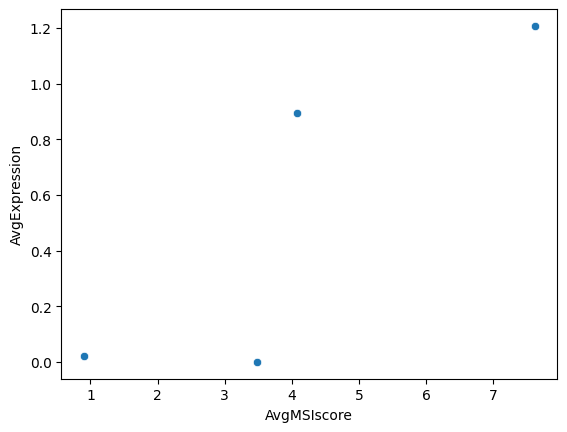

In [912]:
intersecting_up
expression_by_patients = list()

for idx, gene in enumerate(pdata_joanito.var.index):
    if gene in intersecting_up:
        # SC044 
        expression_by_patients.append( ['SC044', dict_PatientID_to_MSI_score['SC044'], gene, pdata_joanito.X[0][idx]] )
        # CRC2783 
        expression_by_patients.append( ['CRC2783', dict_PatientID_to_MSI_score['CRC2783'], gene, pdata_joanito.X[1][idx]] )
        # SC035 
        expression_by_patients.append( ['SC035', dict_PatientID_to_MSI_score['SC035'], gene, pdata_joanito.X[2][idx]] )
        # CRC2817 
        expression_by_patients.append( ['CRC2817', dict_PatientID_to_MSI_score['CRC2817'], gene, pdata_joanito.X[3][idx]] )

expression_by_patients = pd.DataFrame(expression_by_patients, columns=['PatientID', 'AvgMSIscore', 'gene', 'AvgExpression'])
sns.scatterplot(data=expression_by_patients[(expression_by_patients['gene']=='ASCL2')], x='AvgMSIscore', y='AvgExpression', )

#### Chen et al

In [913]:
# Get pseudo-bulk profile
pdata_chen = dc.get_pseudobulk(
    adata_epi_chen_tumor,
    sample_col='PatientID',
    groups_col='MSI_class',
    mode='mean',
    min_cells=0,
    min_counts=0
)

0.657 0.039 True


ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

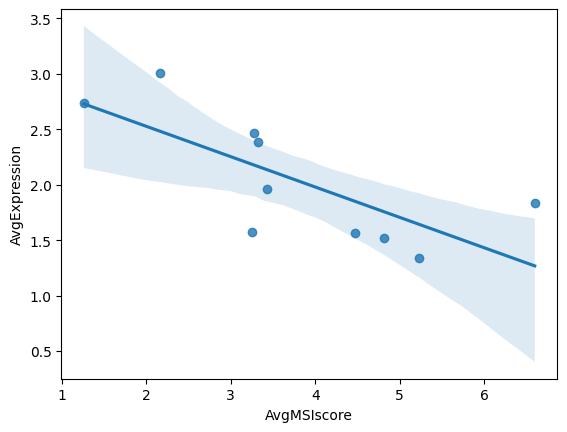

In [950]:
intersecting_up
expression_by_patients = list()

for idx, gene in enumerate(pdata_chen.var.index):
    if gene in intersecting_up.union(intersecting_down):
        # P04
        expression_by_patients.append( ['P04', dict_PatientID_to_MSI_score['P04'], gene, pdata_chen.X[0][idx]] )
        # P21 
        expression_by_patients.append( ['P21', dict_PatientID_to_MSI_score['P21'], gene, pdata_chen.X[1][idx]] )
        # P23 
        expression_by_patients.append( ['P23', dict_PatientID_to_MSI_score['P23'], gene, pdata_chen.X[2][idx]] )
        # P15 
        expression_by_patients.append( ['P15', dict_PatientID_to_MSI_score['P15'], gene, pdata_chen.X[3][idx]] )
        # P19
        expression_by_patients.append( ['P19', dict_PatientID_to_MSI_score['P19'], gene, pdata_chen.X[4][idx]] )
        # P20 
        expression_by_patients.append( ['P20', dict_PatientID_to_MSI_score['P20'], gene, pdata_chen.X[5][idx]] )
        # P22 
        expression_by_patients.append( ['P22', dict_PatientID_to_MSI_score['P22'], gene, pdata_chen.X[6][idx]] )
        # P26 
        expression_by_patients.append( ['P26', dict_PatientID_to_MSI_score['P26'], gene, pdata_chen.X[7][idx]] )
        # P17 
        expression_by_patients.append( ['P17', dict_PatientID_to_MSI_score['P17'], gene, pdata_chen.X[8][idx]] )
        # P18 
        expression_by_patients.append( ['P18', dict_PatientID_to_MSI_score['P18'], gene, pdata_chen.X[9][idx]] )

expression_by_patients = pd.DataFrame(expression_by_patients, columns=['PatientID', 'AvgMSIscore', 'gene', 'AvgExpression'])
gene_MSI_intensity_correlation = list() 

for gene, edf in expression_by_patients.groupby('gene'):
    r, pval = scipy.stats.pearsonr( edf['AvgMSIscore'], edf['AvgExpression'] )
    if gene in intersecting_up:
        gene_MSI_intensity_correlation.append([gene, r, pval, 'UP'])
    else:
        gene_MSI_intensity_correlation.append([gene, r, pval, 'DW'])

gene_MSI_intensity_correlation = pd.DataFrame(gene_MSI_intensity_correlation, columns=['gene', 'r', 'pval', 'type'])
goi = 'S100A6'
print(round(r, 3), round(pval, 3), bool(pval<0.05))
ax = sns.regplot(data=expression_by_patients[(expression_by_patients['gene']==goi)], x='AvgMSIscore', y='AvgExpression',)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
gene_MSI_intensity_correlation

In [951]:
gene_MSI_intensity_correlation

,gene,r,pval,type
0,A1CF,-0.413818,0.234511,DW
1,ABCB1,0.686117,0.028469,UP
2,ABCC3,-0.561657,0.091106,DW
3,ABLIM3,-0.378645,0.280600,DW
4,AC007952.4,0.495014,0.145760,UP
...,...,...,...,...
411,ZNF608,0.784901,0.007158,UP
412,ZNF675,0.766405,0.009719,UP
413,ZNF701,0.758446,0.010997,UP
414,ZNF844,0.170693,0.637299,UP


<Axes: xlabel='r', ylabel='pval'>

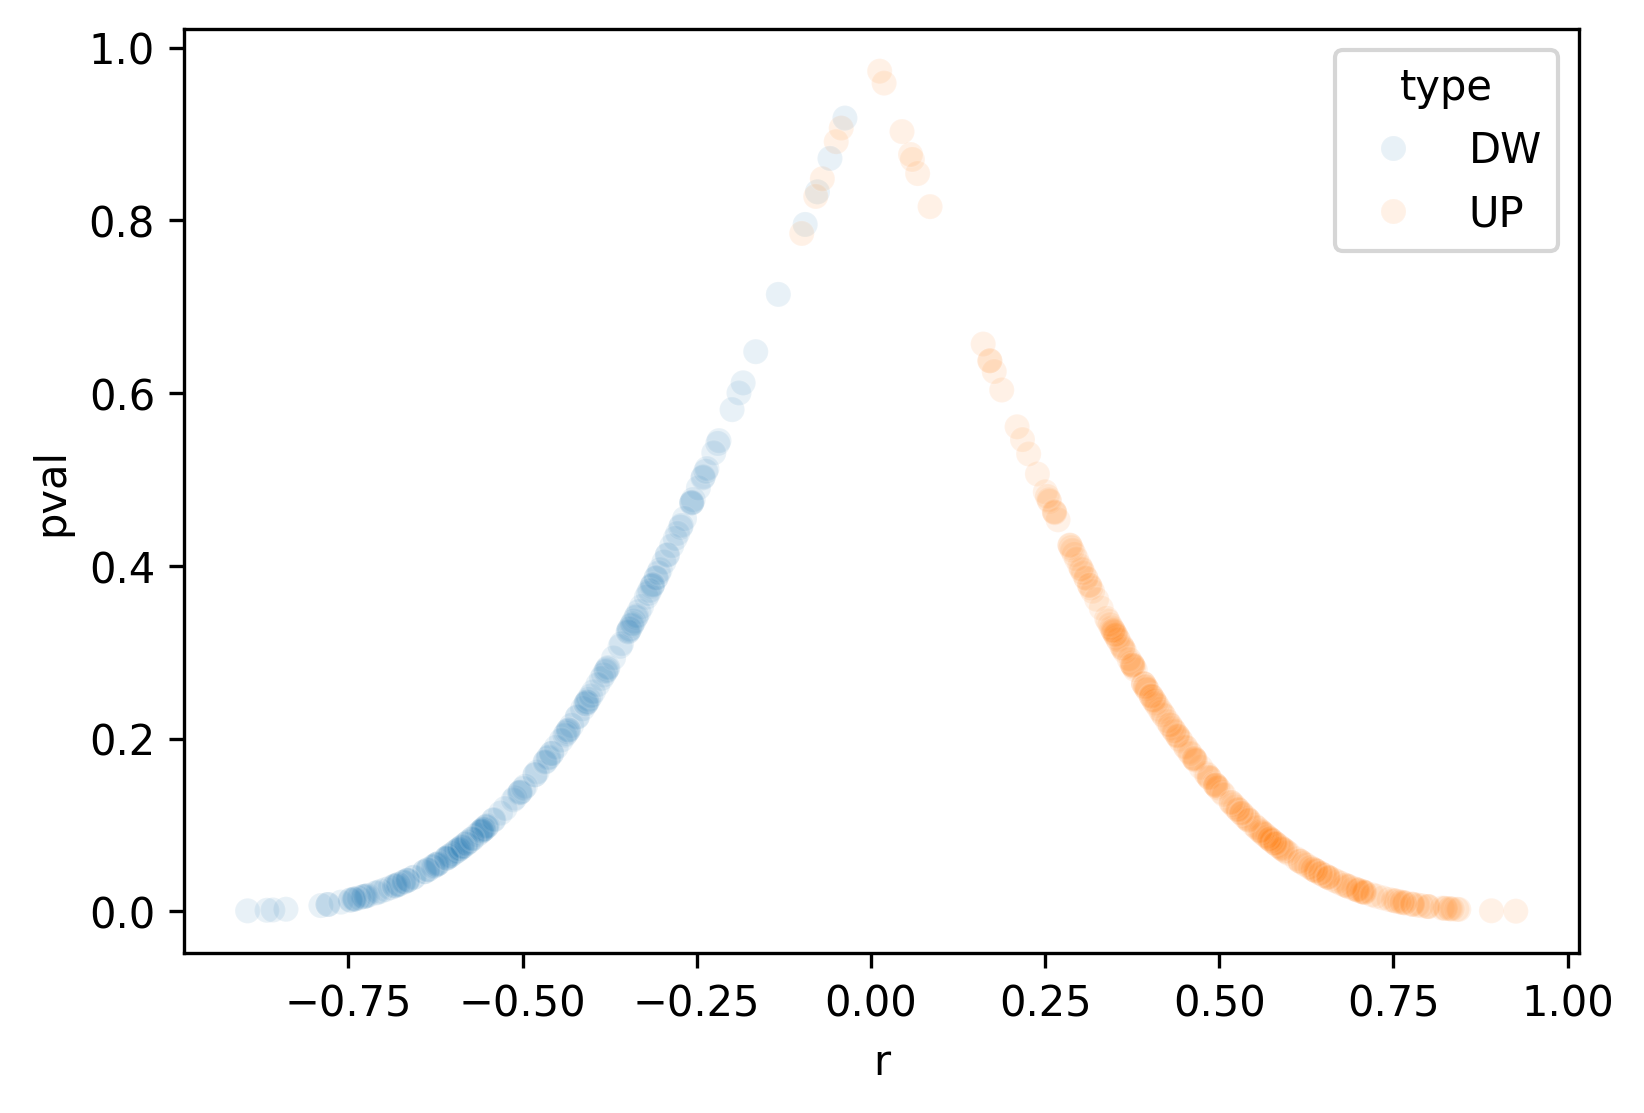

In [955]:
plt.figure(figsize=(6, 4), dpi=300)
sns.scatterplot(data=gene_MSI_intensity_correlation, x='r', y='pval', hue='type', alpha=0.1)

## Human Atlas Protein validation

In [646]:
HumanAtlasProtein = pd.read_csv(f'{DIR_WORKSPACE}/reference/z_program_references/HumanProteinAtlas/rna_single_cell_cluster.tsv', sep='\t')
HumanAtlasProtein.columns = ['geneID', 'gene', 'tissues', 'cluster', 'cell_type', 'read_count', 'nTPM']
HumanAtlasProtein = HumanAtlasProtein[(HumanAtlasProtein['Tissue']=='colon')].copy()

### MSI-H

In [863]:
MSI_H_GenesOfInterest = [ 'RGMB', 'ASCL2', 'SOX4', 'NUPR1', 'PHGDH', 'PRUNE2', 'PIGR',  ]

HumanAtlasProtein_MSI_H = HumanAtlasProtein[(HumanAtlasProtein['gene'].isin(MSI_H_GenesOfInterest))].copy()
HumanAtlasProtein_MSI_H.reset_index(inplace=True, drop=True)
len(set(HumanAtlasProtein_MSI_H['gene'])), len(MSI_H_GenesOfInterest)

(7, 7)

In [840]:
HumanAtlasProtein_MSI_H_collapsed = list()

for gene, edf in HumanAtlasProtein_MSI_H.groupby('gene', observed=True):
    for cell_type, edf2 in edf.groupby('cell_type', observed=True):
        if gene=='PHGDH' and cell_type=='undifferentiated cells': 
            PHDGH_edf2 = edf2.copy()
        HumanAtlasProtein_MSI_H_collapsed.append( [edf2.iloc[0][0], edf2.iloc[0][1], edf2.iloc[0][4], np.sum(edf2['nTPM'])] )

HumanAtlasProtein_MSI_H_collapsed = pd.DataFrame(HumanAtlasProtein_MSI_H_collapsed, columns=['geneID', 'gene', 'cell_type', 'nTPM'])
HumanAtlasProtein_MSI_H_collapsed[(HumanAtlasProtein_MSI_H_collapsed['gene']=='PHGDH')]

,geneID,gene,cell_type,nTPM
12,ENSG00000092621,PHGDH,distal enterocytes,5.0
13,ENSG00000092621,PHGDH,enteroendocrine cells,6.0
14,ENSG00000092621,PHGDH,intestinal goblet cells,4.2
15,ENSG00000092621,PHGDH,paneth cells,7.2
16,ENSG00000092621,PHGDH,t-cells,1.0
17,ENSG00000092621,PHGDH,undifferentiated cells,121.8


In [841]:
# dict_idx_to_z_score = dict()
# for gene, edf in HumanAtlasProtein_MSI_H.groupby('Gene name', observed=True):
#     expressionAvg = np.mean(edf['nTPM'])
#     expressionStd = np.std(edf['nTPM'])

#     for tup in edf.itertuples():
#         dict_idx_to_z_score[tup.Index] = (tup.nTPM-expressionAvg)/expressionStd

# HumanAtlasProtein_MSI_H['nTPM_z'] = [ dict_idx_to_z_score[idx] for idx in HumanAtlasProtein_MSI_H.index ]
# HumanAtlasProtein_MSI_H

In [842]:
dict_idx_to_z_score = dict()
for gene, edf in HumanAtlasProtein_MSI_H_collapsed.groupby('gene', observed=True):
    expressionAvg = np.mean(edf['nTPM'])
    expressionStd = np.std(edf['nTPM'])

    for tup in edf.itertuples():
        dict_idx_to_z_score[tup.Index] = (tup.nTPM-expressionAvg)/expressionStd

HumanAtlasProtein_MSI_H_collapsed['nTPM_z'] = [ dict_idx_to_z_score[idx] for idx in HumanAtlasProtein_MSI_H_collapsed.index ]
HumanAtlasProtein_MSI_H_collapsed.head(2)

,geneID,gene,cell_type,nTPM,nTPM_z
0,ENSG00000183734,ASCL2,distal enterocytes,85.8,0.634977
1,ENSG00000183734,ASCL2,enteroendocrine cells,83.4,0.587796


In [843]:
HumanAtlasProtein_MSI_H_mtx = HumanAtlasProtein_MSI_H_collapsed.pivot(index='cell_type', columns='gene', values='nTPM_z')
HumanAtlasProtein_MSI_H_mtx = HumanAtlasProtein_MSI_H_mtx.reindex( ['t-cells', 'enteroendocrine cells', 'distal enterocytes', 'intestinal goblet cells', 'paneth cells', 'undifferentiated cells'] )

In [844]:
HumanAtlasProtein_MSI_H_mtx

gene,ASCL2,NUPR1,PHGDH,PIGR,PRUNE2,RGMB,SOX4
cell_type,,,,,,,
t-cells,-0.955414,-0.868974,-0.531014,-0.811304,-1.092224,-0.868277,-0.874747
enteroendocrine cells,0.587796,-0.327276,-0.416572,-0.287700,-0.308672,0.476420,-0.537563
distal enterocytes,0.634977,0.088671,-0.439460,2.153878,-0.498624,-0.324853,0.632652
intestinal goblet cells,-0.892506,-0.414335,-0.457771,-0.617441,1.887648,-0.402485,-0.493844
paneth cells,-0.980970,-0.617471,-0.389105,-0.486032,-0.664832,-0.876595,-0.684387
undifferentiated cells,1.606118,2.139385,2.233922,0.048599,0.676704,1.995790,1.957889


### MSI-L

In [778]:
MSI_L_GenesOfInterest = [ 'S100A6', 'S100A10', 'S100A11', 'S100A14', 'S100P',
                         'REG4', 'CD55', 'TFF1', 'TFF3', 'ATOH1', 'MUC2', 'SPINK4',]

HumanAtlasProtein_MSI_L = HumanAtlasProtein[(HumanAtlasProtein['gene'].isin(MSI_L_GenesOfInterest))].copy()
HumanAtlasProtein_MSI_L.reset_index(inplace=True, drop=True)
len(set(HumanAtlasProtein_MSI_L['gene'])), len(MSI_L_GenesOfInterest)

(12, 12)

In [779]:
HumanAtlasProtein_MSI_L_collapsed = list()

for gene, edf in HumanAtlasProtein_MSI_L.groupby('gene', observed=True):
    for cell_type, edf2 in edf.groupby('cell_type', observed=True):
        HumanAtlasProtein_MSI_L_collapsed.append( [edf2.iloc[0][0], edf2.iloc[0][1], edf2.iloc[0][4], np.sum(edf2['nTPM'])] )

HumanAtlasProtein_MSI_L_collapsed = pd.DataFrame(HumanAtlasProtein_MSI_L_collapsed, columns=['geneID', 'gene', 'cell_type', 'nTPM'])
HumanAtlasProtein_MSI_L_collapsed.head(2)

,geneID,gene,cell_type,nTPM
0,ENSG00000172238,ATOH1,distal enterocytes,9.2
1,ENSG00000172238,ATOH1,enteroendocrine cells,2.1


In [780]:
dict_idx_to_z_score = dict()
for gene, edf in HumanAtlasProtein_MSI_L_collapsed.groupby('gene', observed=True):
    expressionAvg = np.mean(edf['nTPM'])
    expressionStd = np.std(edf['nTPM'])

    for tup in edf.itertuples():
        dict_idx_to_z_score[tup.Index] = (tup.nTPM-expressionAvg)/expressionStd

HumanAtlasProtein_MSI_L_collapsed['nTPM_z'] = [ dict_idx_to_z_score[idx] for idx in HumanAtlasProtein_MSI_L_collapsed.index ]
HumanAtlasProtein_MSI_L_collapsed.head(2)

,geneID,gene,cell_type,nTPM,nTPM_z
0,ENSG00000172238,ATOH1,distal enterocytes,9.2,-0.378637
1,ENSG00000172238,ATOH1,enteroendocrine cells,2.1,-0.508927


In [781]:
HumanAtlasProtein_MSI_L_mtx = HumanAtlasProtein_MSI_L_collapsed.pivot(index='cell_type', columns='gene', values='nTPM_z')
HumanAtlasProtein_MSI_L_mtx = HumanAtlasProtein_MSI_L_mtx.reindex( ['t-cells', 'enteroendocrine cells', 'distal enterocytes', 'intestinal goblet cells', 'paneth cells', 'undifferentiated cells'] )

<Axes: xlabel='gene', ylabel='cell_type'>

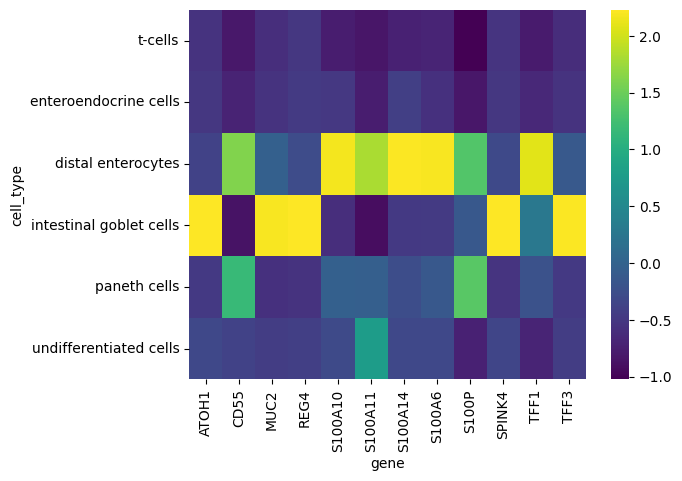

In [782]:
sns.heatmap(HumanAtlasProtein_MSI_L_mtx, annot=False, cmap='viridis')

In [838]:
MSI_H_GenesOfInterest

['PIGR', 'PRUNE2', 'PIK3R3', 'RGMB', 'ASCL2', 'SOX4', 'NUPR1', 'PHGDH']

In [ ]:
HumanAtlasProtein_adata = sc.concat( [sc.AnnData(HumanAtlasProtein_MSI_L_mtx), sc.AnnData(HumanAtlasProtein_MSI_H_mtx)], join='outer' )
with matplotlib.rc_context(rc={'figure.dpi': 400, 'figure.figsize': (4, 3)}):
    sc.pl.matrixplot(HumanAtlasProtein_adata, var_names={ 'Enterocyte-enriched genes' : ['S100A6', 'S100A10', 'S100A11', 'S100A14', 'S100P', 'TFF1', 'PIGR', 'CD55'],
                                                        'Goblet-enriched genes' : ['ATOH1', 'MUC2', 'REG4', 'SPINK4', 'TFF3', 'PRUNE2'], 
                                                        'Stem-enriched genes' : ['ASCL2', 'RGMB', 'NUPR1', 'SOX4', 'PHGDH'],}, 
                    groupby='cell_type', 
                    categories_order=['t-cells', 'enteroendocrine cells', 'paneth cells', 'distal enterocytes', 'intestinal goblet cells', 'undifferentiated cells'],
                    swap_axes=True,
                    )

<Axes: xlabel='gene', ylabel='cell_type'>

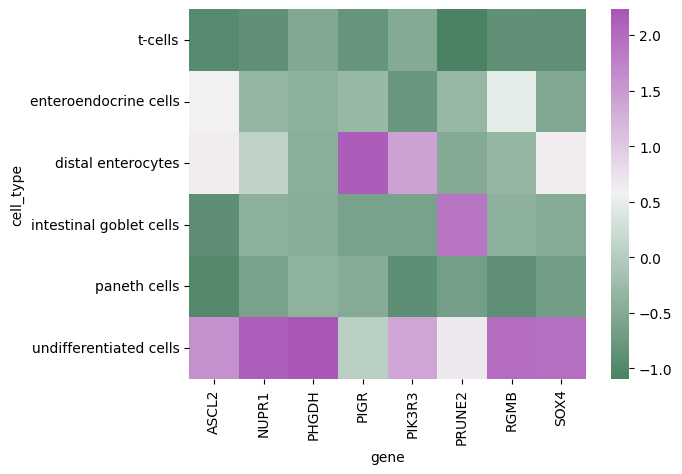

In [801]:
sns.heatmap(HumanAtlasProtein_MSI_H_mtx, annot=False, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), )

In [783]:
raise ValueError

ValueError: 

In [ ]:
with open(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/EnrichR/BackgroundGenes.txt', 'w') as f:
    for gene in set(chen_tumor_DEG_summary['gene']).union(set(joanito_tumor_DEG_summary['gene'])):
        f.write(f'{gene}\n')

In [ ]:
for gene in intersecting_down:
    print(gene)

177

<Axes: xlabel='Combined Score', ylabel='Term'>

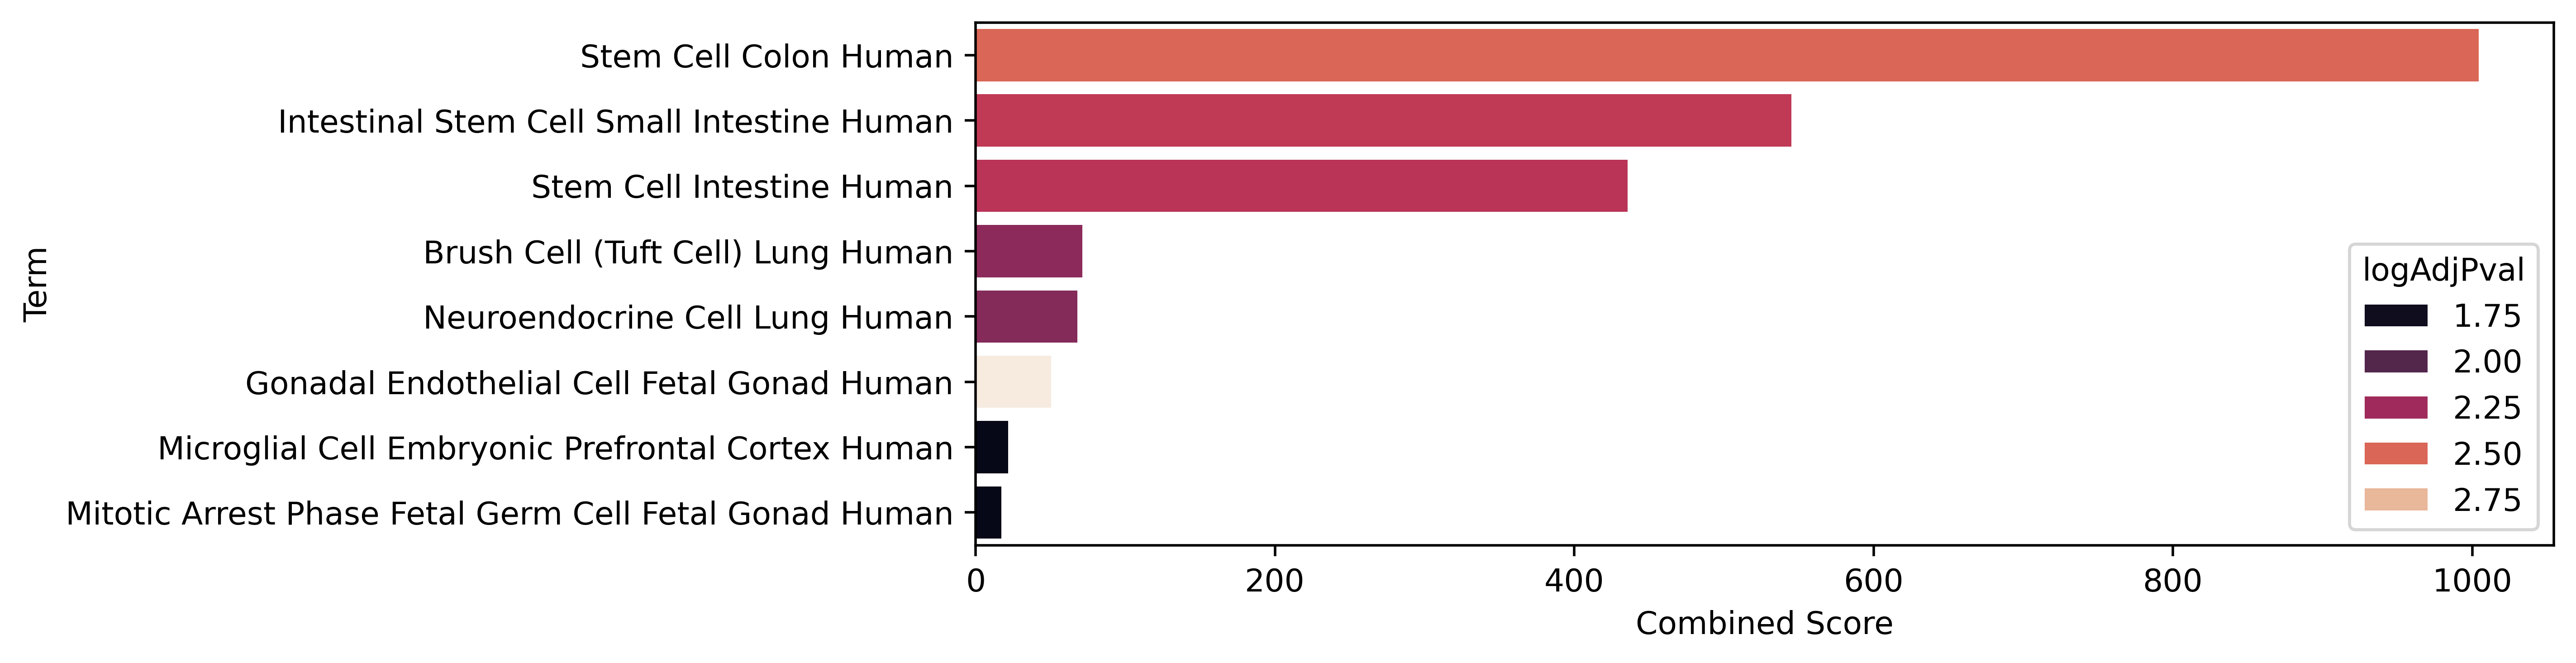

In [ ]:
intersecting_up_enrichR_out = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/EnrichR/IntersectingUp.CellMarker2024.tsv', sep='\t')

intersecting_up_enrichR_out['organism'] = [ t.split(' ')[-1] for t in intersecting_up_enrichR_out['Term'] ]
intersecting_up_enrichR_out['n_genes'] = [ int(overlap.split('/')[-1]) for overlap in intersecting_up_enrichR_out['Overlap'] ]

intersecting_up_enrichR_out = intersecting_up_enrichR_out[(intersecting_up_enrichR_out['organism']=='Human') & 
                                                              (intersecting_up_enrichR_out['Adjusted P-value']<=0.05) & 
                                                              (intersecting_up_enrichR_out['n_genes']>=5)]
intersecting_up_enrichR_out = intersecting_up_enrichR_out.sort_values('Adjusted P-value',).head(8)

result = intersecting_up_enrichR_out.groupby(["Term"])['Combined Score'].aggregate(np.median).reset_index().sort_values('Combined Score', ascending=False)
# result = intersecting_up_enrichR_out.groupby(["Term"])['Odds Ratio'].aggregate(np.median).reset_index().sort_values('Odds Ratio', ascending=False)

intersecting_up_enrichR_out['logAdjPval'] = [ -np.log10(p) for p in intersecting_up_enrichR_out['Adjusted P-value'] ]

plt.figure(figsize=(9, 3), dpi=500)
sns.barplot(data=intersecting_up_enrichR_out, y='Term', x='Combined Score', order=result['Term'], hue='logAdjPval', palette=sns.color_palette('rocket', as_cmap=True,))

<Axes: xlabel='Combined Score', ylabel='Term'>

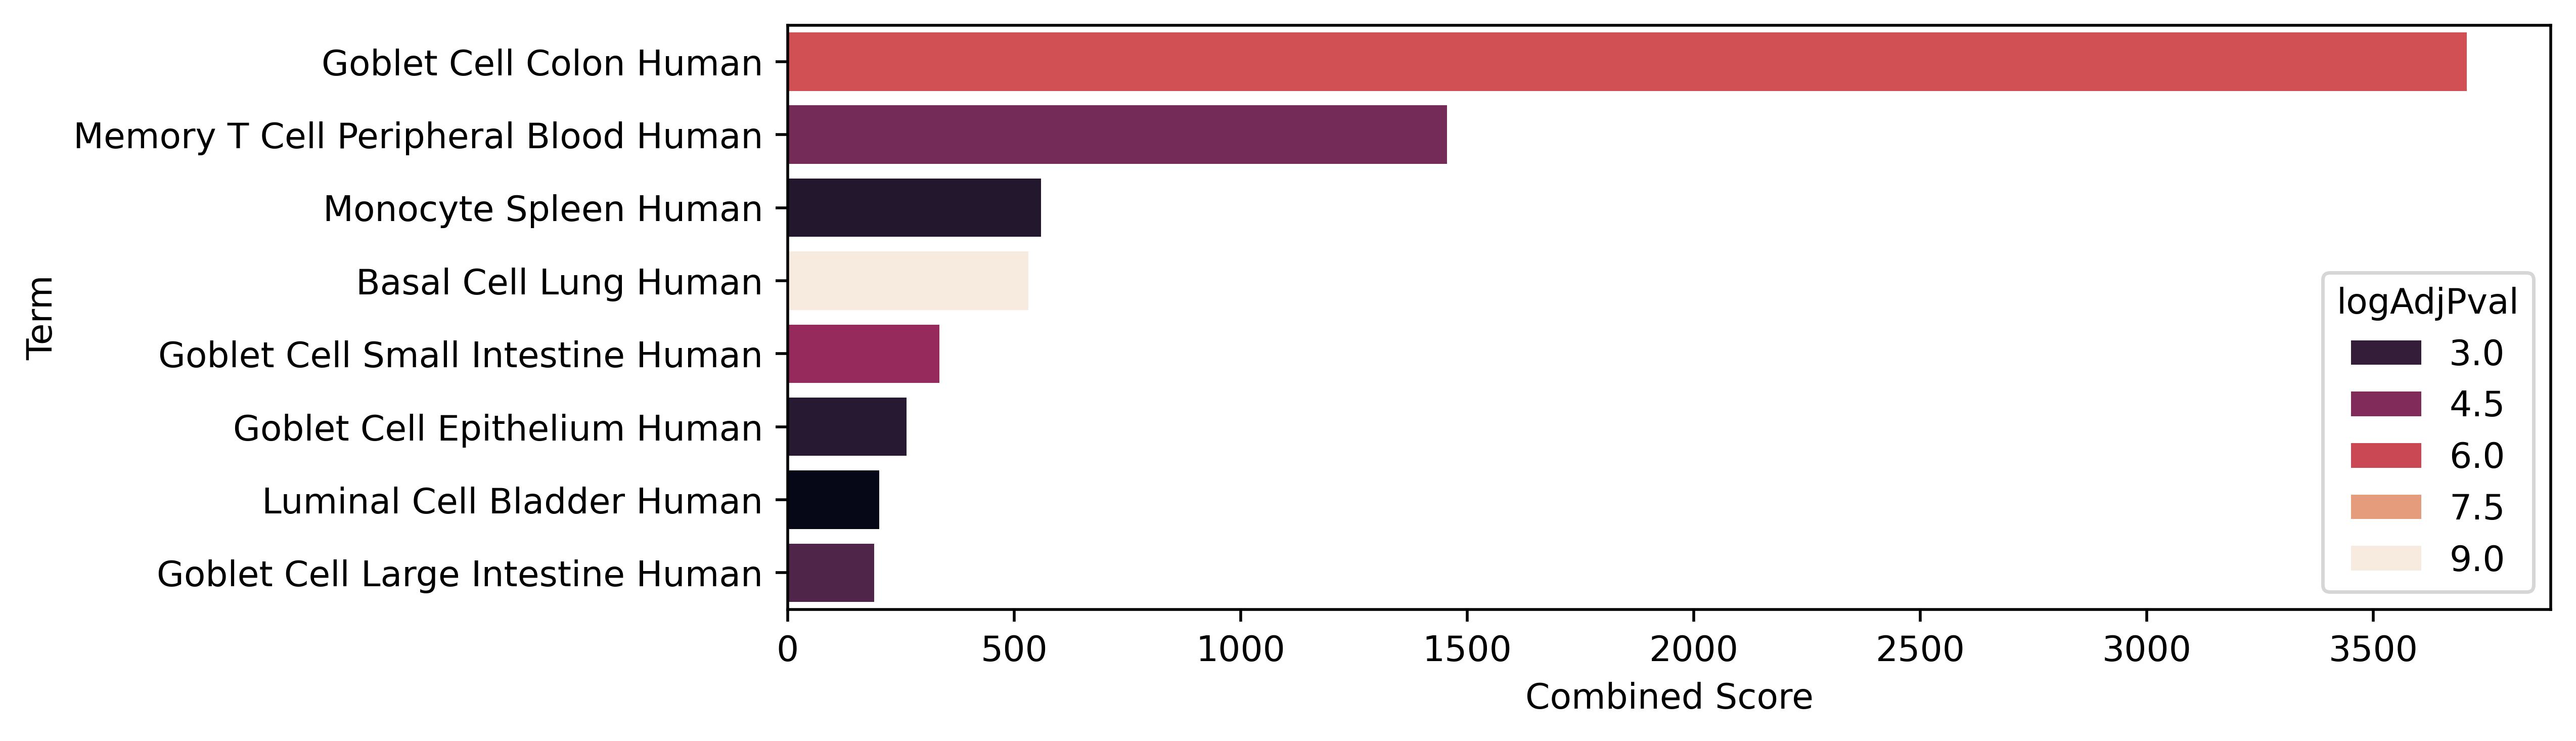

In [ ]:
intersecting_down_enrichR_out = pd.read_csv(f'{DIR_WORKSPACE}/data/public/processed_data/CRC_MSI_intensity_analysis/EnrichR/IntersectingDown.CellMarker2024.tsv', sep='\t')

intersecting_down_enrichR_out['organism'] = [ t.split(' ')[-1] for t in intersecting_down_enrichR_out['Term'] ]
intersecting_down_enrichR_out['n_genes'] = [ int(overlap.split('/')[-1]) for overlap in intersecting_down_enrichR_out['Overlap'] ]

intersecting_down_enrichR_out = intersecting_down_enrichR_out[(intersecting_down_enrichR_out['organism']=='Human') & 
                                                              (intersecting_down_enrichR_out['Adjusted P-value']<=0.05) & 
                                                              (intersecting_down_enrichR_out['n_genes']>=5)]
intersecting_down_enrichR_out = intersecting_down_enrichR_out.sort_values('Adjusted P-value',).head(8)

result = intersecting_down_enrichR_out.groupby(["Term"])['Combined Score'].aggregate(np.median).reset_index().sort_values('Combined Score', ascending=False)
# result = intersecting_down_enrichR_out.groupby(["Term"])['Odds Ratio'].aggregate(np.median).reset_index().sort_values('Odds Ratio', ascending=False)

intersecting_down_enrichR_out['logAdjPval'] = [ -np.log10(p) for p in intersecting_down_enrichR_out['Adjusted P-value'] ]

plt.figure(figsize=(9, 3), dpi=500)
sns.barplot(data=intersecting_down_enrichR_out, y='Term', x='Combined Score', order=result['Term'], hue='logAdjPval', palette=sns.color_palette('rocket', as_cmap=True,))

In [ ]:
intersecting_down_enrichR_out

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,organism,n_genes,logAdjPval
0,Basal Cell Lung Human,13/67,2.376868e-12,9.626313e-10,0,0,19.840560,531.037306,IFI27L2;FGFBP1;GPX2;S100A2;AQP3;SERPINB5;S100A...,Human,67,9.016540
5,Goblet Cell Small Intestine Human,7/33,1.677641e-07,1.132408e-05,0,0,21.449774,334.631634,SPINK4;MUC2;GSN;REP15;REG4;TFF1;BCAS1,Human,33,4.945997
8,Goblet Cell Large Intestine Human,6/36,5.915644e-06,2.662040e-04,0,0,15.836257,190.635444,PTPRN2;CEACAM6;CEACAM5;TSPAN1;FER1L6;BCAS1,Human,36,3.574785
9,Goblet Cell Epithelium Human,4/16,4.283893e-05,1.734977e-03,0,0,26.123314,262.749948,SPINK4;MUC2;TFF3;ATOH1,Human,16,2.760706
16,Luminal Cell Bladder Human,3/12,4.238402e-04,9.973884e-03,0,0,25.978927,201.756353,GPX2;PPARG;KRT20,Human,12,2.001136
17,Macrophage Brain Human,5/50,4.432837e-04,9.973884e-03,0,0,8.737080,67.461621,SLC66A3;BHLHE40;FXYD5;LYZ;S100A11,Human,50,2.001136
19,Myeloid-derived Suppressor Cell Peripheral Blo...,3/13,5.457891e-04,1.052593e-02,0,0,23.379310,175.655255,CEACAM6;CEACAM5;ICAM1,Human,13,1.977739
20,Basal Cell Airway Epithelium Human,3/13,5.457891e-04,1.052593e-02,0,0,23.379310,175.655255,DST;S100A2;LAMA3,Human,13,1.977739
22,Monocyte Fetal Kidney Human,18/596,6.831615e-04,1.202958e-02,0,0,2.544624,18.547200,ANXA2;MTMR11;SYTL1;LYZ;PLXDC2;CRIP1;PYCARD;LGA...,Human,596,1.919749
28,CD4+ T Cell Peripheral Blood Human,3/16,1.038723e-03,1.450630e-02,0,0,17.980106,123.519079,S100A4;S100A11;S100A10,Human,16,1.838443
